In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imutils import paths
import random
import cv2
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [4]:
epoch_num = 50
init_lr = 1e-3
batchsize = 64
class_num = 2
norm_size = 64
depth = 3

label_dir = {
    "SN": 0,
    "PN": 0,
    "SC": 1,
    "PC": 1,
}

In [12]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(norm_size,norm_size,depth))

58892288/58889256 [==============================] - 6s 0us/step


In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [14]:
model = Sequential()
conv_base.trainable = False
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_num, activation='sigmoid'))

In [15]:
#Loading the data
print("[INFO] loading images...")
data = []
labels = []
imagePaths = sorted(list(paths.list_images("../Images/Training_Set/")))#args["dataset"])))
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (norm_size, norm_size))
    image = img_to_array(image)
    data.append(image)

    label_str = imagePath.split(os.path.sep)[-2]

    labels.append(label_dir[label_str])

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

[INFO] loading images...


In [16]:
# partition the data into 80% training_total and 20% testing
#partition the training_total data into 75% training data and 25% validation data 
(trainX_t, testX, trainY_t, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
(trainX, valX, trainY, valY) = train_test_split(trainX_t, trainY_t, test_size=0.25, random_state=42)

#labels = to_categorical(labels, num_classes=CLASS_NUM)
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=class_num)
valY = to_categorical(valY, num_classes=class_num)
testY = to_categorical(testY, num_classes=class_num)


In [17]:
# construct the image generator for data augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, 
                                   fill_mode="nearest")
train_generator = train_datagen.flow(trainX, trainY, batch_size=batchsize)

In [18]:
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(valX, valY, batch_size=batchsize)

In [19]:
opt = Adam(lr=init_lr, decay=init_lr/epoch_num)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [20]:
# train the network
print("[INFO] training network...")
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001) #automatically alter the learning rate
checkpoint = ModelCheckpoint(filepath="0422_binary_test1.h5", monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max', period=1)
H = model.fit_generator(train_generator, steps_per_epoch=len(trainX)//batchsize,
              validation_data=val_generator, validation_steps=len(valX)//batchsize,
              epochs=epoch_num, verbose=1, callbacks=[checkpoint,reduce_lr])

[INFO] training network...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 9 steps
Epoch 1/50
27/28 [===========================>..] - ETA: 0s - loss: 0.6297 - accuracy: 0.6611
Epoch 00001: val_accuracy improved from -inf to 0.74826, saving model to 0422_binary_test1.h5
28/28 [==============================] - 26s 931ms/step - loss: 0.6260 - accuracy: 0.6643 - val_loss: 0.5301 - val_accuracy: 0.7483
Epoch 2/50
27/28 [===========================>..] - ETA: 0s - loss: 0.4869 - accuracy: 0.7656
Epoch 00002: val_accuracy improved from 0.74826 to 0.77344, saving model to 0422_binary_test1.h5
28/28 [==============================] - 26s 919ms/step - loss: 0.4856 - accuracy: 0.7662 - val_loss: 0.4883 - val_accuracy: 0.7734
Epoch 3/50
27/28 [===========================>..] - ETA: 0s - loss: 0.4439 - accuracy: 0.7890
Epoch 00003: val_accuracy did not improve from 0.77344
28/28 [=======

27/28 [===========================>..] - ETA: 0s - loss: 0.3476 - accuracy: 0.8435
Epoch 00026: val_accuracy did not improve from 0.84896
28/28 [==============================] - 27s 968ms/step - loss: 0.3437 - accuracy: 0.8461 - val_loss: 0.4173 - val_accuracy: 0.8229
Epoch 27/50
27/28 [===========================>..] - ETA: 0s - loss: 0.3355 - accuracy: 0.8546
Epoch 00027: val_accuracy did not improve from 0.84896
28/28 [==============================] - 27s 971ms/step - loss: 0.3363 - accuracy: 0.8534 - val_loss: 0.3812 - val_accuracy: 0.8429
Epoch 28/50
27/28 [===========================>..] - ETA: 0s - loss: 0.3369 - accuracy: 0.8514
Epoch 00028: val_accuracy did not improve from 0.84896
28/28 [==============================] - 27s 959ms/step - loss: 0.3362 - accuracy: 0.8514 - val_loss: 0.3934 - val_accuracy: 0.8359
Epoch 29/50
27/28 [===========================>..] - ETA: 0s - loss: 0.3382 - accuracy: 0.8520
Epoch 00029: val_accuracy did not improve from 0.84896
28/28 [=========

In [25]:
H = model.fit_generator(train_generator, steps_per_epoch=len(trainX)//batchsize,
              validation_data=val_generator, validation_steps=len(valX)//batchsize,
              epochs=epoch_num, verbose=1, callbacks=[checkpoint,reduce_lr])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 28 steps, validate for 9 steps
Epoch 1/50
27/28 [===========================>..] - ETA: 0s - loss: 0.3077 - accuracy: 0.8657
Epoch 00001: val_accuracy did not improve from 0.85677
28/28 [==============================] - 25s 888ms/step - loss: 0.3066 - accuracy: 0.8661 - val_loss: 0.3807 - val_accuracy: 0.8420
Epoch 2/50
27/28 [===========================>..] - ETA: 0s - loss: 0.2905 - accuracy: 0.8719
Epoch 00002: val_accuracy did not improve from 0.85677
28/28 [==============================] - 25s 903ms/step - loss: 0.2938 - accuracy: 0.8700 - val_loss: 0.4087 - val_accuracy: 0.8229
Epoch 3/50
27/28 [===========================>..] - ETA: 0s - loss: 0.3356 - accuracy: 0.8543
Epoch 00003: val_accuracy did not improve from 0.85677
28/28 [==============================] - 26s 918ms/step - loss: 0.3311 - accuracy: 0.8576 - val_loss: 0.3956 - val_accuracy: 0.8429
Epoch 4/50
27/28 [===========================>..] - ETA: 0s - loss

Epoch 29/50
27/28 [===========================>..] - ETA: 0s - loss: 0.2731 - accuracy: 0.8835
Epoch 00029: val_accuracy did not improve from 0.86892
28/28 [==============================] - 25s 895ms/step - loss: 0.2733 - accuracy: 0.8821 - val_loss: 0.3402 - val_accuracy: 0.8602
Epoch 30/50
27/28 [===========================>..] - ETA: 0s - loss: 0.2751 - accuracy: 0.8867
Epoch 00030: val_accuracy did not improve from 0.86892
28/28 [==============================] - 25s 905ms/step - loss: 0.2777 - accuracy: 0.8841 - val_loss: 0.3416 - val_accuracy: 0.8576
Epoch 31/50
27/28 [===========================>..] - ETA: 0s - loss: 0.2660 - accuracy: 0.8955
Epoch 00031: val_accuracy did not improve from 0.86892
28/28 [==============================] - 25s 899ms/step - loss: 0.2690 - accuracy: 0.8928 - val_loss: 0.3408 - val_accuracy: 0.8628
Epoch 32/50
27/28 [===========================>..] - ETA: 0s - loss: 0.2847 - accuracy: 0.8710
Epoch 00032: val_accuracy did not improve from 0.86892
28/2

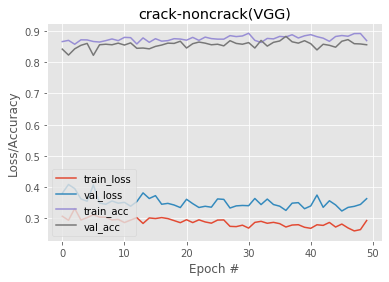

In [27]:
# plot the training loss and accuracy
plt.style.use("ggplot")
N = epoch_num
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("crack-noncrack(VGG)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("0422_binary_test1.png", dpi=600)

In [ ]:
model.predict(testX)


In [ ]:
import matplotlib.pyplot as plt
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = NUM_EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("ResNet:Training Loss and Accuracy on crack damage level")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Resnet_plot.png")
